In [1]:
%load_ext autoreload
%autoreload 2

import os
import logging

import json

from tradingdb.utils import *
from tradingdb.ORM.utils import *

logger = logging.getLogger()
logger.setLevel(logging.INFO)
# create file handler which logs even debug messages
handler = logging.StreamHandler()
handler.setLevel(logging.NOTSET)
format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(format)


logger.addHandler(handler)


# get all the NASDAQ symbols

In [2]:
symbols=download_nasdaq_symbols()

In [3]:
len(symbols)

4361

In [4]:
symbols.head()

Symbol                                              Name Last Sale  \
0   AACG  ATA Creativity Global American Depositary Shares   $1.3393   
1   AACI           Armada Acquisition Corp. I Common Stock    $10.55   
2  AACIW                Armada Acquisition Corp. I Warrant    $0.064   
3   AADI                 Aadi Bioscience Inc. Common Stock    $5.365   
4    AAL         American Airlines Group Inc. Common Stock   $16.635   

   Net Change % Change    Market Cap        Country  IPO Year    Volume  \
0     -0.0307  -2.241%  4.235157e+07          China    2008.0     13759   
1     -0.0400  -0.378%  0.000000e+00  United States    2021.0     29276   
2     -0.0048  -6.977%  0.000000e+00  United States    2021.0      1750   
3      0.0050   0.093%  1.311045e+08  United States       NaN     94960   
4     -0.1550  -0.923%  1.086870e+10  United States       NaN  10360207   

                   Sector                                    Industry  
0  Consumer Discretionary                        Educational Services  
1                 Finance                                Blank Checks  
2                 Finance                                Blank Checks  
3             Health Care  Biotechnology: Pharmaceutical Preparations  
4  Consumer Discretionary               Air Freight/Delivery Services

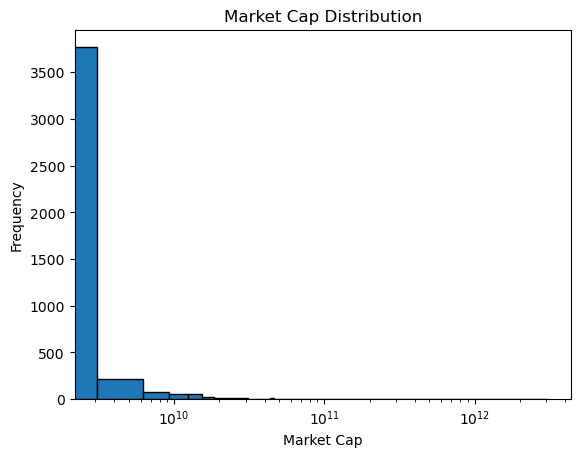

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# Create a histogram of the 'Age' column
plt.hist(symbols['Market Cap'], bins=1000, edgecolor='black')

# Add labels and a title
plt.xlabel('Market Cap')
plt.ylabel('Frequency')
plt.title('Market Cap Distribution')
plt.xscale('log')
# Show the plot
plt.show()


271


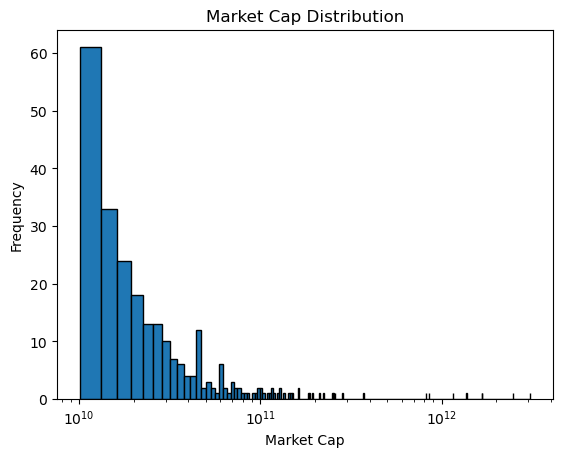

In [6]:
# mega: >200B
# large: 10B-200B
# medium: 2B-10B
billion=1000*1000*1000
symbols_large=symbols[symbols['Market Cap']>10*billion]
print(len(symbols_large))
plt.hist(symbols_large['Market Cap'], bins=1000, edgecolor='black')

# Add labels and a title
plt.xlabel('Market Cap')
plt.ylabel('Frequency')
plt.title('Market Cap Distribution')
plt.xscale('log')
# Show the plot
plt.show()


In [7]:
print(list(symbols_large['Symbol']))

['AAL', 'AAPL', 'ABNB', 'ACGL', 'ACGLN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AEPPZ', 'AGNCL', 'AGNCM', 'AGNCN', 'AGNCO', 'AGNCP', 'AKAM', 'ALGN', 'ALNY', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'APA', 'APP', 'ARCC', 'ARGX', 'ASML', 'ATVI', 'AVGO', 'AXON', 'AZN', 'AZPN', 'BATRA', 'BATRK', 'BGNE', 'BIDU', 'BIIB', 'BKNG', 'BKR', 'BMRN', 'BNTX', 'BSY', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CELH', 'CFLT', 'CG', 'CHK', 'CHKP', 'CHRW', 'CHTR', 'CINF', 'CMCSA', 'CME', 'COIN', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'CZR', 'DDOG', 'DKNG', 'DLTR', 'DOCU', 'DOX', 'DXCM', 'EA', 'EBAY', 'ENPH', 'ENTG', 'EQIX', 'ERIC', 'ERIE', 'ETSY', 'EVRG', 'EXAS', 'EXC', 'EXPD', 'EXPE', 'FANG', 'FAST', 'FATBP', 'FCNCA', 'FITB', 'FITBI', 'FITBO', 'FITBP', 'FIVE', 'FLEX', 'FOX', 'FOXA', 'FSLR', 'FTNT', 'FWONA', 'FWONK', 'GDEV', 'GEHC', 'GEN', 'GFS', 'GILD', 'GLPI', 'GOOG', 'GOOGL', 'GRAB', 'HBAN', 'HBANM', 'HBANP', 'HOLX', 'HON', 'HOOD', 'HSIC', 'HST', 'HTHT', 'HZNP', 'ICLR', 'IDXX', 'IEP', 'ILMN',

In [8]:
handler.setLevel(logging.DEBUG)
DBNAME=os.path.abspath("../data/master.db")

def create_all_nasdaq_large(symbols):

    session=get_new_session(DBNAME)
    with session.begin() as mysession:
        eid=mysession.query(stock.Exchange.id).filter(stock.Exchange.name=="NASDAQ").one()[0]
        cid=mysession.query(stock.Currency.id).filter(stock.Currency.name=="USD").one()[0]
        

        for i,st in enumerate(symbols):
            st.replace('/','-')
            #if i>10: break
            print(i,st)
            
            isthere=mysession.query(stock.Stock).filter(stock.Stock.symbol==st).all()
            
            if len(isthere)==0:
                print("Query  YF for symbol",st)
                ticker=yf.Ticker(st)
                try:
                    info=ticker.info
                    if info is None: continue
                    if 'longName' in info.keys():
                        name=info['longName']
                    elif 'shortName' in info.keys():
                        name=info['shortName']
                    else:
                        name=st

                    if 'exchange' not in info.keys():
                        print("Missing exchange name")
                        print(ticker)
                        json.dump(info, fh)
                        continue

                    exchange=info['exchange']
                    #print("Exchange ",exchange)
                    if exchange != "NMS":
                        print("Exchanche for %s is %s . Shouldn't it be NMS?"%(ticker,exchange))
                        #json.dump(info, fh)
                        continue

                    if 'currency' in info.keys():
                        
                        currency=info['currency'].upper()

                        if currency != 'USD':
                            print("Currency for %s is %s"%(ticker,currency))
                            print("not sure what to do... skipping")
                            
                        else:
                            newstock=stock.Stock(company=name,symbol=st,yf_symbol=st,
                                    exchange_id=eid,currency_id=cid)    
                            mysession.add(newstock)
                            print("...added!!!")

                    else:
                        print("Missing currency!")
                        continue
                except:
                    print("Some problem encountered with ",st)

                    continue
            else:
                print("The symbol is already there")


create_all_nasdaq_large(list(symbols_large['Symbol']))



0 AAL
The symbol is already there
1 AAPL
The symbol is already there
2 ABNB
The symbol is already there
3 ACGL
The symbol is already there
4 ACGLN
The symbol is already there
5 ADBE
The symbol is already there
6 ADI
The symbol is already there
7 ADP
The symbol is already there
8 ADSK
The symbol is already there
9 AEP
The symbol is already there
10 AEPPZ
The symbol is already there
11 AGNCL
The symbol is already there
12 AGNCM
The symbol is already there
13 AGNCN
The symbol is already there
14 AGNCO
The symbol is already there
15 AGNCP
The symbol is already there
16 AKAM
The symbol is already there
17 ALGN
The symbol is already there
18 ALNY
The symbol is already there
19 AMAT
The symbol is already there
20 AMD
The symbol is already there
21 AMGN
The symbol is already there
22 AMZN
The symbol is already there
23 ANSS
The symbol is already there
24 APA
The symbol is already there
25 APP
The symbol is already there
26 ARCC
Query  YF for symbol ARCC
Exchanche for yfinance.Ticker object <AR

# add yfinance information to the database

In [9]:
# sample few yfinance and get the headers to create an appropriate table
DBNAME=os.path.abspath("../data/master.db")

session=get_new_session(DBNAME)
ys=[]
with session.begin() as mysession:
    res=mysession.query(stock.Stock).join(stock.Exchange).filter(stock.Exchange.id==1).all()
    for i,r in enumerate(res):
        try:
            print(i,r.yf_symbol)
            ys.append(yf.Ticker(r.yf_symbol).info)
        except:
            print("issue with :",r.yf_symbol)
            continue


0 AAPL
1 ABNB
2 ACGL
3 ACGLN
4 ADBE
5 ADI
6 ADP
7 ADSK
8 AEP
9 AEPPZ
10 AGNCL
11 AGNCM
12 AGNCN
13 AGNCO
14 AGNCP
15 AKAM
16 ALGN
17 ALNY
18 AMAT
19 AMD
20 AMGN
21 AMZN
22 ANSS
23 APA
24 APP
25 ARGX
26 ASML
27 ATVI
28 AVGO
29 AXON
30 AZPN
31 BATRA
32 BATRK
33 BGNE
34 BIDU
35 BIIB
36 BKNG
37 BKR
38 BMRN
39 BNTX
40 BSY
41 CCEP
42 CDNS
43 CDW
44 CEG
45 CFLT
46 CG
47 CHK
48 CHKP
49 CHRW
50 CHTR
51 CINF
52 CMCSA
53 CME
54 COIN
55 COST
56 CPRT
57 CRWD
58 CSCO
59 CSGP
60 CSX
61 CTAS
62 CTSH
63 CZR
64 DDOG
65 DKNG
66 DLTR
67 DOCU
68 DOX
69 DXCM
70 EA
71 EBAY
72 ENTG
73 EQIX
74 ERIC
75 ERIE
76 ETSY
77 EVRG
78 EXC
79 EXPD
80 EXPE
81 FANG
82 FAST
83 FCNCA
84 FITB
85 FITBI
86 FITBO
87 FITBP
88 FIVE
89 FLEX
90 FOX
91 FOXA
92 FSLR
93 FTNT
94 FWONA
95 FWONK
96 GEHC
97 GEN
98 GFS
99 GILD
100 GLPI
101 GOOG
102 GOOGL
103 GRAB
104 HBAN
105 HBANM
106 HBANP
107 HOLX
108 HON
109 HOOD
110 HSIC
111 HST
112 HTHT
113 HZNP
114 ICLR
115 IDXX
116 IEP
117 ILMN
118 INCY
119 INTC
120 INTU
121 ISRG
122 JBHT
123 JD
124

In [19]:
df=pd.DataFrame.from_dict(ys)
df.drop("companyOfficers",axis=1,inplace=True)
df.drop("sharesShort",axis=1,inplace=True)
df.drop("sharesShortPriorMonth",axis=1,inplace=True)
df.drop("sharesShortPreviousMonthDate",axis=1,inplace=True,errors='ignore')
df.drop("dateShortInterest",axis=1,inplace=True,errors='ignore')
df.drop("sharesPercentSharesOut",axis=1,inplace=True,errors='ignore')
df.drop("shortRatio",axis=1,inplace=True,errors='ignore')
df.drop("shortPercentOfFloat",axis=1,inplace=True,errors='ignore')



#df.head()
#pd.set_option('max_columns', None)
#pd.set_option('display.max_rows', None)
from sqlalchemy import create_engine
print(DBNAME)
engine = create_engine('sqlite:///'+DBNAME, echo=False)

with engine.begin() as connection:
    df.to_sql('yf_info', con=connection,if_exists='append')



/Users/davidebranduardi/Projects/Finance/trading-toolbox/tradingdb/tradingdb/data/master.db


In [21]:
handler.setLevel(logging.DEBUG)
#DBNAME=os.path.abspath("../data/master.db")
session=get_new_session(DBNAME)
from datetime import datetime, timedelta

# retrieve all the LSE symbols
deltadays=14
# open/close in UTC 
#UK	8:00 am to 4:30 pm
#US	2:30 pm to 9:00 pm
time_end=datetime.today().replace(hour=4, minute=30, microsecond=0)
# covid crisis: start new era from ftse slump (23 march)
time_start = time_end - timedelta(days=deltadays)
time_start=time_start.replace(hour=8, minute=0, microsecond=0)
print(time_start,time_end)

def add_df_to_yfsymbol(session,symbol,df,interval):
    # get stock id
    with session.begin() as mysession:
            for index, row in df.iterrows():
                # convert name into time
                sid=mysession.query(stock.Stock.id).filter(stock.Stock.yf_symbol==symbol).one()[0]
                pid=mysession.query(stock.Period.id).filter(stock.Period.name==interval).one()[0]
                print(index)
                q=mysession.query(stock.Price)
                q=q.filter(stock.Price.stock_id==sid)
                q=q.filter(stock.Price.period_id==pid)
                r=q.filter(stock.Price.date==index.to_pydatetime()).one_or_none()
                if r is None:
                    p=stock.Price(
                                stock_id=sid,
                                period_id=pid,
                                date=index.to_pydatetime(),  
                                open=row['Open'],
                                low=row['Low'],
                                high=row['High'],
                                close=row['Close'],
                                adjusted_close=row['Adj Close'],
                                volume=row['Volume'])
                    mysession.add(p)

#[1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]          
intervals=['1d','1h','5m']

with session.begin() as mysession:
    q=mysession.query(stock.Stock).join(stock.Exchange).filter(stock.Exchange.name=="NASDAQ").all()
    symbols=[ r.yf_symbol for r in q ]
    #symbols=symbols[:5]
    print(symbols)
    for interval in intervals:
        dfd=download_data_from_yfsymbols(symbols,time_start,time_end,interval=interval)
        for k,v in dfd.items():
            print(k)# ,v.head())
            add_df_to_yfsymbol(session,k,v,interval)
            #break
        

2023-07-17 08:00:59 2023-07-31 04:30:59
['AAPL', 'ABNB', 'ACGL', 'ACGLN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AEPPZ', 'AGNCL', 'AGNCM', 'AGNCN', 'AGNCO', 'AGNCP', 'AKAM', 'ALGN', 'ALNY', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'APA', 'APP', 'ARGX', 'ASML', 'ATVI', 'AVGO', 'AXON', 'AZPN', 'BATRA', 'BATRK', 'BGNE', 'BIDU', 'BIIB', 'BKNG', 'BKR', 'BMRN', 'BNTX', 'BSY', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CFLT', 'CG', 'CHK', 'CHKP', 'CHRW', 'CHTR', 'CINF', 'CMCSA', 'CME', 'COIN', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'CZR', 'DDOG', 'DKNG', 'DLTR', 'DOCU', 'DOX', 'DXCM', 'EA', 'EBAY', 'ENTG', 'EQIX', 'ERIC', 'ERIE', 'ETSY', 'EVRG', 'EXC', 'EXPD', 'EXPE', 'FANG', 'FAST', 'FCNCA', 'FITB', 'FITBI', 'FITBO', 'FITBP', 'FIVE', 'FLEX', 'FOX', 'FOXA', 'FSLR', 'FTNT', 'FWONA', 'FWONK', 'GEHC', 'GEN', 'GFS', 'GILD', 'GLPI', 'GOOG', 'GOOGL', 'GRAB', 'HBAN', 'HBANM', 'HBANP', 'HOLX', 'HON', 'HOOD', 'HSIC', 'HST', 'HTHT', 'HZNP', 'ICLR', 'IDXX', 'IEP', 'ILMN', 'INCY', 'INTC', 'INTU'

In [22]:
# now try doing a plot
import mplfinance as fplt

print("MPLFinance Version : {}".format(fplt.__version__))

DBNAME=os.path.abspath("../data/master.db")
session=get_new_session(DBNAME)

with session.begin() as mysession:
    # get the period and the stock so you can filkter
    q=mysession.query(stock.Price).join(stock.Stock).join(stock.Period)
    q=q.filter(stock.Period.name=='1h')
    q=q.filter(stock.Stock.yf_symbol=='MSFT')
    r=q.all()
    d=[{'date':row.date,'Open':row.open,'Close':row.close,'High':row.high,'Low':row.low,'Volume':row.volume} for row in r]
df=pd.DataFrame.from_dict(d)

MPLFinance Version : 0.12.9b7


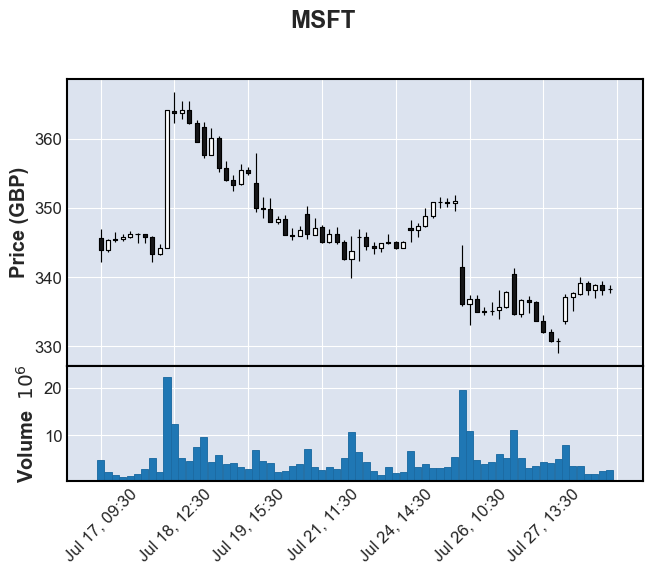

In [23]:
df['Datetime'] = pd.to_datetime(df['date'])
df = df.set_index('Datetime')

fplt.plot(
            df,
            type='candle',
            title='MSFT',
            ylabel='Price (GBP)',
            volume=True
        )